In [1]:
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
tab = matplotlib.cm.get_cmap('tab10')
import os
from glob import glob

import pandas as pd

from itertools import groupby
import h5py

plt.rcParams['text.usetex'] = False
from scipy.optimize import curve_fit

/tmp/ipykernel_26453/1859429441.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab = matplotlib.cm.get_cmap('tab10')


In [2]:
dt_base = 1.25e-4 #sec
dx_base = 0.03 #um

#set so that bessel function produces the same diffusion coef as
#   a cluster of size 50 in the fast-diffusing D ~ 1/N_mol model
D_LAT = 0.043125 #base diffusion scale
D_TCR = 0.064 #base diffusion prob (this is now corrected to 10x the old value)

diff_factor = [0.1, 0.5, 1]
t_factor = [1,    1,   1, 3, 10]
x_factor = [0.25, 0.5, 1, 1, 1]
kinds = ['LAT','source']

exist_fun = {
    'LAT':'create_none',
    'source':'diffusing_fast_point_source_with_loss_negfdbk_and_depletion'
}

N_run = 50
N_per = 10

In [3]:
batches = {
    0.25:'big',
    0.5: 'med',
    1:'small'
}

for t,x in zip(t_factor, x_factor):
    with open(f'cmds_{batches[x]}.sh','a') as f:
        for k,kind in enumerate(kinds):
            for d,df in enumerate(diff_factor):
                
                print(kind,df,t,x)
                dt = dt_base/t
                dx = dx_base*x
                
                if kind == 'LAT':
                    exist_kws = {}
                else:
                    p_diff = df*D_TCR
                    exist_kws = {'D_TCR_free':p_diff, 
                                 'D_TCR_bound':p_diff,
                                 'dx':30, #always 30 becuase this is only used for cluster radius calculations
                                 'k_on_TCR':0, 'k_off_TCR':0,
                                 'pMHC_density':0,
                                 'k_create_max_0':0, 'k_create_max_1':0,
                                 'k_degrade_min':0, 'k_degrade_max':0,
                                 'degrade_infl':1,
                                 'deg_weights':{0:1, 1:1},
                                 'k_deactivate':0}

                kws = {'init_kws':{'kind':kind,'source_locs':np.zeros([k,4])},

                       'diffusion_kws':{'D_LAT_diff_test':df*D_LAT,
                                        'dx':30}, #nm
                                           #always 30 becuase this is only used for cluster radius calculations

                       'update_binding_kws':{},
                       'update_exist_kws':exist_kws,

                       'squared_deviation':{'kind':kind},
                      }

                pkl.dump(kws, open(f'kws/{kind}_d{df}_t{t}_x{x}_kws.pkl','wb'))

                for j in range(N_run):
                    f.write('python ../../code/LAT_cluster_sim.py '+\
                            f'-N {N_per} '+\
                            f'-T 120 -dt {dt} '+\
                            f'-grid_size {151*dx_base} -dx {dx} '+\
                            f'-record_every_Nth {int(0.1/dt)} '+\
                            '-write_every_Nth 100 '+\
                            '-N_save 0 '+\
                            '-summary_funcs squared_deviation '+\
                            '-binding_function no_binding '+\
                            '-init_function initialize_single '+\
                            f'-update_exist_function {exist_fun[kind]} '+\
                            '-diffusion_function diffusion_bessel_push '+\
                            f'-kw_pkl kws/{kind}_d{df}_t{t}_x{x}_kws.pkl '+\
                            f'-outfile_base results/{kind}_d{df}_t{t}_x{x}_{j}\n')

LAT 0.1 1 0.25
LAT 0.5 1 0.25
LAT 1 1 0.25
source 0.1 1 0.25
source 0.5 1 0.25
source 1 1 0.25
LAT 0.1 1 0.5
LAT 0.5 1 0.5
LAT 1 1 0.5
source 0.1 1 0.5
source 0.5 1 0.5
source 1 1 0.5
LAT 0.1 1 1
LAT 0.5 1 1
LAT 1 1 1
source 0.1 1 1
source 0.5 1 1
source 1 1 1
LAT 0.1 3 1
LAT 0.5 3 1
LAT 1 3 1
source 0.1 3 1
source 0.5 3 1
source 1 3 1
LAT 0.1 10 1
LAT 0.5 10 1
LAT 1 10 1
source 0.1 10 1
source 0.5 10 1
source 1 10 1


In [4]:
complete = np.zeros([2,3,5,500])

for k,kind in enumerate(kinds):
    for d,df in enumerate(diff_factor):
        for i,(t,x) in enumerate(zip(t_factor, x_factor)):
            for j in range(N_run):
                data = h5py.File(f'results/{kind}_d{df}_t{t}_x{x}_{j}_summary_funcs.h5',
                                 'r')['squared_deviation'][:]
                complete[k,d,i,j*N_per:(j+1)*N_per] = np.any(data[:,-100:]!=0,axis=1)

complete = complete.astype(bool)
print(N_run*N_per - np.sum(complete,axis=3))

[[[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]


In [5]:
x,y = np.meshgrid(range(151),range(151))
mixed_MSD = np.mean((x-75)**2 +(y-75)**2)*0.03**2
mixed_MSD

3.42

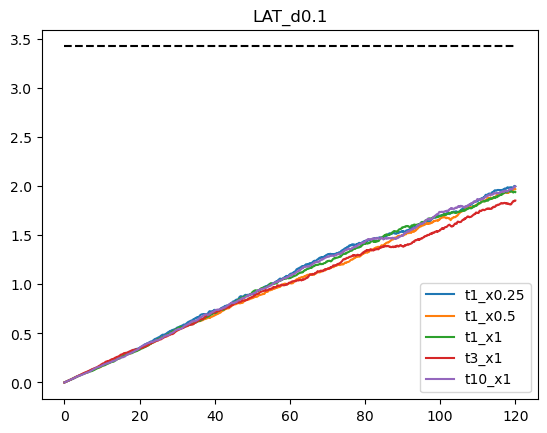

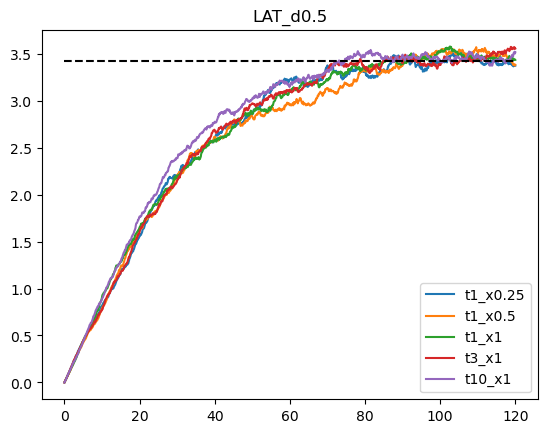

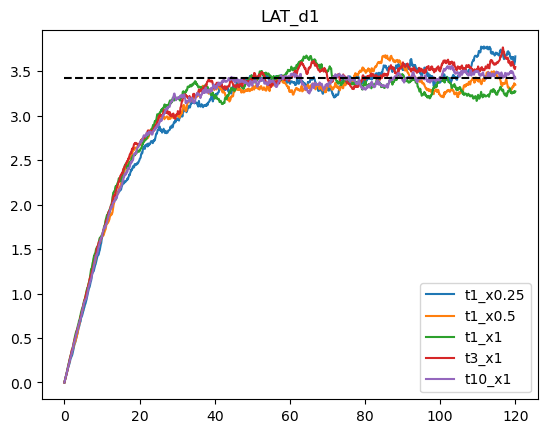

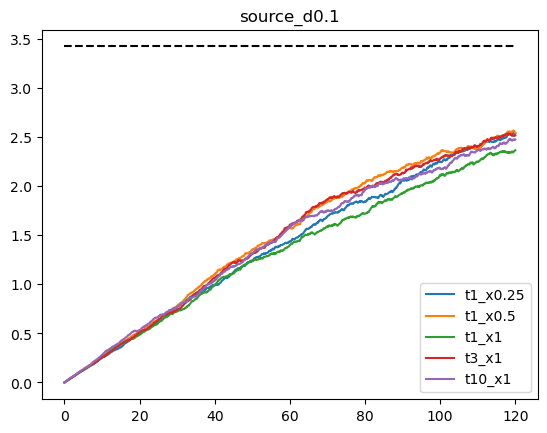

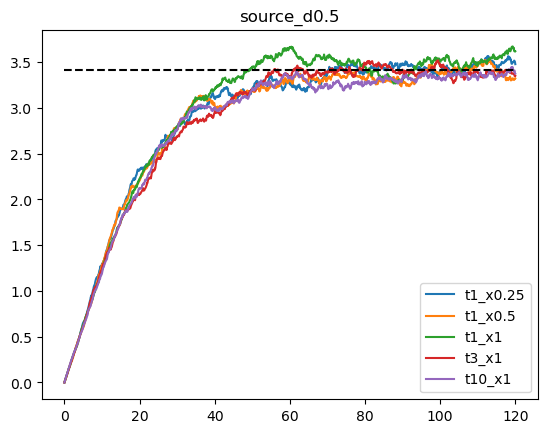

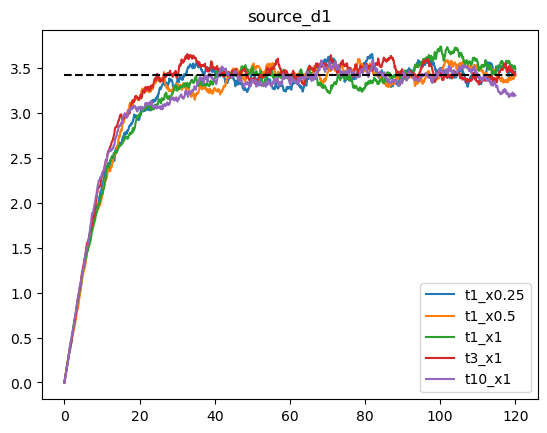

In [6]:
summary = {}
summary['time'] = np.array(range(1201))/10
for k,kind in enumerate(kinds):
    for d,df in enumerate(diff_factor):
        plt.figure()
        for i,(t,x) in enumerate(zip(t_factor, x_factor)):
            data = np.zeros([500,1201])
            for j in range(N_run):
                data[j*N_per:(j+1)*N_per,:] = h5py.File(f'results/{kind}_d{df}_t{t}_x{x}_{j}_summary_funcs.h5',
                                                      'r')['squared_deviation'][:]
            data = data*((0.03*x)**2) #convert to um^2
            MSD = np.mean(data,axis=0)
            summary[f'{kind}_d{df}_t{t}_x{x}'] = MSD
            plt.plot(summary['time'],MSD,label=f't{t}_x{x}')
        plt.legend()
        
        plt.plot([0,120],[mixed_MSD]*2,'k--')
            
        plt.title(f'{kind}_d{df}')
summary = pd.DataFrame(summary)

In [7]:
summary.head()

,time,LAT_d0.1_t1_x0.25,LAT_d0.1_t1_x0.5,LAT_d0.1_t1_x1,LAT_d0.1_t3_x1,LAT_d0.1_t10_x1,LAT_d0.5_t1_x0.25,LAT_d0.5_t1_x0.5,LAT_d0.5_t1_x1,LAT_d0.5_t3_x1,...,source_d0.5_t1_x0.25,source_d0.5_t1_x0.5,source_d0.5_t1_x1,source_d0.5_t3_x1,source_d0.5_t10_x1,source_d1_t1_x0.25,source_d1_t1_x0.5,source_d1_t1_x1,source_d1_t3_x1,source_d1_t10_x1
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.1,0.001809,0.001746,0.001789,0.001562,0.001712,0.009163,0.008500,0.008464,0.008377,...,0.014086,0.011633,0.011644,0.012713,0.013379,0.027532,0.025549,0.025369,0.027391,0.026204
2,0.2,0.003566,0.003496,0.003303,0.003492,0.003305,0.017020,0.016693,0.016834,0.017114,...,0.025878,0.023588,0.024671,0.026269,0.025173,0.054616,0.052620,0.053449,0.053525,0.051629
3,0.3,0.005162,0.005067,0.004761,0.005035,0.005155,0.025743,0.026122,0.023454,0.024161,...,0.040068,0.036211,0.035519,0.038817,0.039593,0.078794,0.079614,0.079220,0.078610,0.077017
4,0.4,0.006580,0.006864,0.006583,0.006523,0.006764,0.033523,0.035055,0.032486,0.032287,...,0.052551,0.049686,0.047250,0.049862,0.053181,0.101397,0.108227,0.104762,0.101709,0.103316


In [8]:
def line(x,slope):
    return x*slope

In [9]:
expected = {
    'LAT':4*D_LAT,
    'source': 4*D_TCR
}
for col in summary.columns[1:]:
    d = float(col.split('_')[1].replace('d',''))
    kind = col.split('_')[0]
    good_idx = summary[col] < mixed_MSD/10
    params,_ = curve_fit(line, summary.loc[good_idx,'time'],summary.loc[good_idx,col],p0=[0.1])
    print(params,params[0]/(expected[kind]*d),col)

[0.01775849] 1.0294777285286596 LAT_d0.1_t1_x0.25
[0.01700023] 0.9855202920841374 LAT_d0.1_t1_x0.5
[0.01673423] 0.9701004422869854 LAT_d0.1_t1_x1
[0.01828318] 1.059894640919096 LAT_d0.1_t3_x1
[0.0169577] 0.983055276286217 LAT_d0.1_t10_x1
[0.09098151] 1.0548581342091896 LAT_d0.5_t1_x0.25
[0.08576119] 0.994332667559148 LAT_d0.5_t1_x0.5
[0.0841018] 0.975093296613887 LAT_d0.5_t1_x1
[0.0906582] 1.0511096149102093 LAT_d0.5_t3_x1
[0.08614719] 0.9988080030389178 LAT_d0.5_t10_x1
[0.15632776] 0.9062478724675163 LAT_d1_t1_x0.25
[0.17469449] 1.0127216863538198 LAT_d1_t1_x0.5
[0.18443295] 1.069176522961035 LAT_d1_t1_x1
[0.17875255] 1.0362466448142373 LAT_d1_t3_x1
[0.17346231] 1.0055786234849087 LAT_d1_t10_x1
[0.02466751] 0.9635744471343471 source_d0.1_t1_x0.25
[0.02672664] 1.044009339785234 source_d0.1_t1_x0.5
[0.02560066] 1.000025863657612 source_d0.1_t1_x1
[0.02527825] 0.9874315402951818 source_d0.1_t3_x1
[0.02766549] 1.0806832026614293 source_d0.1_t10_x1
[0.12612999] 0.9853905289609634 source_d0

In [11]:
summary = {}
summary['time'] = np.array(range(1201))/10
for k,kind in enumerate(kinds):
    for d,df in enumerate(diff_factor):
        for i,(t,x) in enumerate(zip(t_factor, x_factor)):
            data = np.zeros([500,1201])
            for j in range(N_run):
                data[j*N_per:(j+1)*N_per,:] = h5py.File(f'results/{kind}_d{df}_t{t}_x{x}_{j}_summary_funcs.h5',
                                                      'r')['squared_deviation'][:]
            data = data*((0.03*x)**2) #convert to um^2
            for r in range(5):
                MSD = np.mean(data[100*r:100*(r+1),:],axis=0)
                summary[f'{kind}_d{df}_t{t}_x{x}_rep{r}'] = MSD
summary = pd.DataFrame(summary)
summary.head()

,time,LAT_d0.1_t1_x0.25_rep0,LAT_d0.1_t1_x0.25_rep1,LAT_d0.1_t1_x0.25_rep2,LAT_d0.1_t1_x0.25_rep3,LAT_d0.1_t1_x0.25_rep4,LAT_d0.1_t1_x0.5_rep0,LAT_d0.1_t1_x0.5_rep1,LAT_d0.1_t1_x0.5_rep2,LAT_d0.1_t1_x0.5_rep3,...,source_d1_t3_x1_rep0,source_d1_t3_x1_rep1,source_d1_t3_x1_rep2,source_d1_t3_x1_rep3,source_d1_t3_x1_rep4,source_d1_t10_x1_rep0,source_d1_t10_x1_rep1,source_d1_t10_x1_rep2,source_d1_t10_x1_rep3,source_d1_t10_x1_rep4
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.1,0.001625,0.001995,0.001709,0.001794,0.001921,0.001775,0.001744,0.001616,0.001917,...,0.030726,0.027540,0.025695,0.027954,0.025038,0.030726,0.025029,0.023463,0.027666,0.024138
2,0.2,0.002882,0.004444,0.003522,0.003485,0.003498,0.003499,0.003838,0.002995,0.003469,...,0.063558,0.060183,0.045585,0.052794,0.045504,0.046674,0.054711,0.050805,0.052353,0.053604
3,0.3,0.005301,0.005064,0.005372,0.004931,0.005143,0.005220,0.005971,0.003951,0.005326,...,0.082530,0.088713,0.071991,0.080631,0.069183,0.065556,0.076068,0.081747,0.079425,0.082287
4,0.4,0.006625,0.005793,0.007482,0.006131,0.006872,0.006593,0.007893,0.005508,0.007504,...,0.110331,0.113247,0.096129,0.102708,0.086130,0.091845,0.100917,0.112860,0.106245,0.104715


In [12]:
summary.to_csv('MSD_vs_time.csv')

In [13]:
info = {
    'D_LAT':D_LAT,
    'D_TCR':D_TCR,
    'diff_factor':[0.1, 0.5, 1],
    't_factor':[1,    1,   1, 3, 10],
    'x_factor':[0.25, 0.5, 1, 1, 1],
    'kinds':['LAT','source'],
    'dt_base':1.25e-4, #sec
    'dx_base':0.03 #um
}
pkl.dump(info, open('diffusion_info.pkl','wb'))